In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV

In [157]:
df = pd.read_csv("training_dataset.csv")

In [158]:
categorical_columns = [
    'pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya',
    'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
    'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya'
]

In [159]:
y = df["berlangganan_deposito"]
X = df.drop(columns=["berlangganan_deposito", "customer_number"])

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [161]:
class ReplaceUnknown(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.replace("unknown", np.nan)

In [162]:
numerical_features = [
    'usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
    'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
    'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
    'suku_bunga_euribor_3bln', 'jumlah_pekerja'
]

In [163]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ]), numerical_features),
    ('cat', Pipeline([
        ('replace_unknown', ReplaceUnknown()),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_columns)
])

In [164]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [165]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [166]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)
best_rf = grid_rf.best_estimator_

# Logistic Regression
param_grid_lr = {
    'C': [0.1, 1.0, 10],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_res, y_train_res)
best_lr = grid_lr.best_estimator_

# XGB
# param_grid_xgb = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 5],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1]
# }

# xgb_base = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42
# )

# grid_xgb = GridSearchCV(
#     xgb_base,
#     param_grid_xgb,
#     cv=3,
#     scoring='f1',
#     n_jobs=-1,
#     verbose=1
# )
# grid_xgb.fit(X_train_res, y_train_res)
# best_xgb = grid_xgb.best_estimator_

c:\Users\axell\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [167]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), 
                ('lr', best_lr), 
                ],
    voting='soft'
)
voting_clf.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, random_state=42,
                                                 solver='liblinear'))],
                 voting='soft')

In [168]:
# Predict and evaluate
y_pred = voting_clf.predict(X_test_processed)
y_proba = voting_clf.predict_proba(X_test_processed)[:, 1]

In [169]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4061
           1       0.50      0.54      0.52       523

    accuracy                           0.89      4584
   macro avg       0.72      0.74      0.73      4584
weighted avg       0.89      0.89      0.89      4584


ROC AUC Score: 0.7933


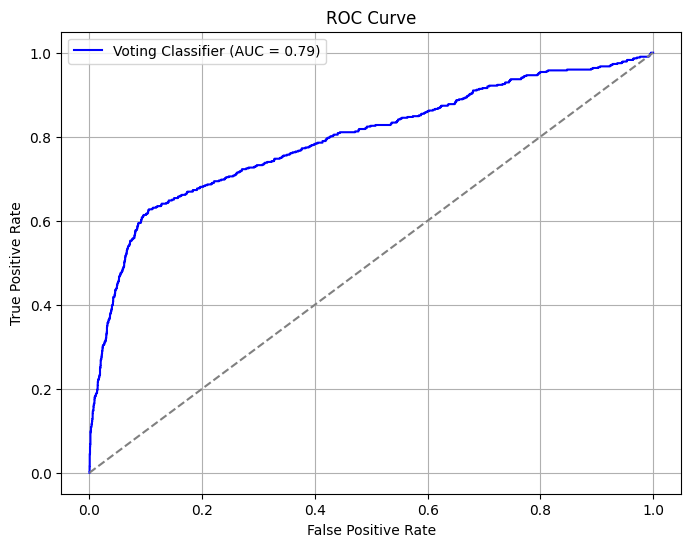

In [170]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()